
## Emerging Trends in Data Technology

## **Brain Tumour MRI Classification Using Deep Learning**

### Final Case Study - *Fundamentals of Medical Image Processing (on Brain Tumor MRI Dataset)*

### By Shaheer Khan

------------------------------------------------------------------------------------------

The goal of this project is to build a professional, end-to-end image classification pipeline that can accurately detect brain tumors from MRI images using deep learning.

We will apply key medical image processing concepts—such as intensity normalization, histogram analysis, and basic segmentation—adapted from Neeraj Sharma’s notebook to the JPEG-based Brain Tumor MRI dataset.

The final deliverables will include a modular, well-documented Jupyter notebook, a trained model, visual diagnostics like confusion matrices and Grad-CAM heatmaps, and a formal report summarizing methods, results, and insights. The project emphasizes accuracy, interpretability, reproducibility, and code quality.

------------------------------------------------------------------------------------------

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




---

### 1 - Setup & Class Distribution Check

---



In [79]:
import os
import cv2
import math
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from typing import Tuple
import matplotlib.pyplot as plt
from collections import Counter
from scipy import ndimage as ndi
import tensorflow_probability as tfp
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure, morphology
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [3]:
# configuration
base_path = '/content/drive/MyDrive/archive'
splits     = ['Training', 'Testing']
classes    = ['glioma', 'meningioma', 'pituitary', 'notumor']
img_ext    = ('.png', '.jpg', '.jpeg')

In [4]:
# count images per class per split
summary = []
for split in splits:
    split_path = os.path.join(base_path, split)
    counts = {cls: len([f for f in os.listdir(os.path.join(split_path, cls))
                        if f.lower().endswith(img_ext)])
              for cls in classes}
    summary.append([split] + [counts[c] for c in classes] + [sum(counts.values())])

# assemble summary table
print("__" * 30)
print(" ")
columns = ['Split'] + [c.capitalize() for c in classes] + ['Total']
df = pd.DataFrame(summary, columns=columns)
df.loc['Total'] = ['Total'] + df.iloc[:, 1:-1].sum().tolist() + [df['Total'].sum()]
print(df.to_string(index=False))
print(" ")
print("__" * 30)


____________________________________________________________
 
   Split  Glioma  Meningioma  Pituitary  Notumor  Total
Training    1321        1339       1487     1595   5742
 Testing     300         306        300      405   1311
   Total    1621        1645       1787     2000   7053
 
____________________________________________________________


---

### 2 — Core Image Loading & Pre-processing

---

In [5]:
# configuration
target_size: Tuple[int, int] = (224, 224)
equalise_default: bool = False

In [6]:
def _letterbox(img: np.ndarray, target):
    """
    Resize while preserving aspect ratio, then pad to fixed size.
    Always returns shape (H, W, 1) for grayscale input.
    """
    th, tw = target
    h, w   = img.shape[:2]
    scale  = min(tw / w, th / h)
    new_w, new_h = int(round(w * scale)), int(round(h * scale))

    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    if resized.ndim == 2:                     # (H,W) → (H,W,1)
        resized = resized[..., None]

    canvas = np.zeros((th, tw, 1), dtype=resized.dtype)
    top  = (th - new_h) // 2
    left = (tw - new_w) // 2
    canvas[top:top + new_h, left:left + new_w, 0] = resized[:, :, 0]
    return canvas

In [7]:
def load_image(path: str,
               target: Tuple[int, int] = target_size,
               equalise: bool = equalise_default) -> np.ndarray:

    """
    Read a grayscale MRI slice, optionally equalise its histogram,
    resize with letterbox padding, and return float32 array in [0, 1].
    """

    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(path)

    if equalise:
        img = cv2.equalizeHist(img)

    img = _letterbox(img, target)
    img = img.astype(np.float32) / 255.0
    return img[..., None]            # shape (H, W, 1)

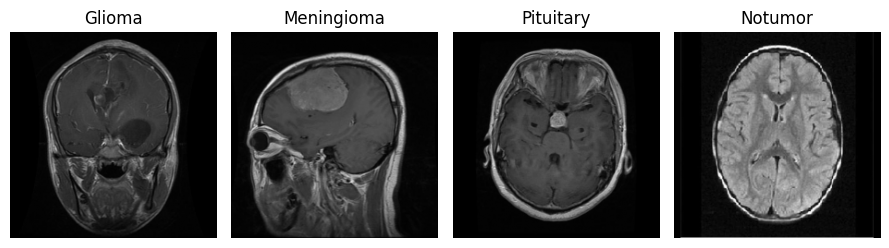

 
Processed batch shapes: [(224, 224, 1, 1), (224, 224, 1, 1), (224, 224, 1, 1), (224, 224, 1, 1)]


In [8]:
# quick demonstration
demo_paths = []
for cls in classes:
    cls_dir = os.path.join(base_path, 'Training', cls)
    demo_paths.append(os.path.join(cls_dir,
                    random.choice([f for f in os.listdir(cls_dir) if f.lower().endswith(img_ext)])))

fig, axes = plt.subplots(1, 4, figsize=(9, 3))
for ax, cls, p in zip(axes, classes, demo_paths):
    proc = load_image(p)
    ax.imshow(proc.squeeze(), cmap='gray', vmin=0, vmax=1)
    ax.set_title(cls.capitalize())
    ax.axis('off')
plt.tight_layout()
plt.show()

print(" ")
print("Processed batch shapes:", [load_image(p).shape for p in demo_paths])

---

### 3 — Intensity Histogram Analysis

---

In [9]:
# parameters
sample_per_class = 400
bins             = 256
colors           = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

def sample_pixels(cls_name, n_samples):

    """Randomly sample up to n_samples images from one class and return flattened pixel values."""

    cls_dir = os.path.join(base_path, 'Training', cls_name)
    files   = random.sample(
        [f for f in os.listdir(cls_dir) if f.lower().endswith(img_ext)],
        min(n_samples, len(os.listdir(cls_dir))))
    pix = []
    for f in files:
        im = cv2.imread(os.path.join(cls_dir, f), cv2.IMREAD_GRAYSCALE)
        pix.append(im.flatten())
    return np.concatenate(pix)

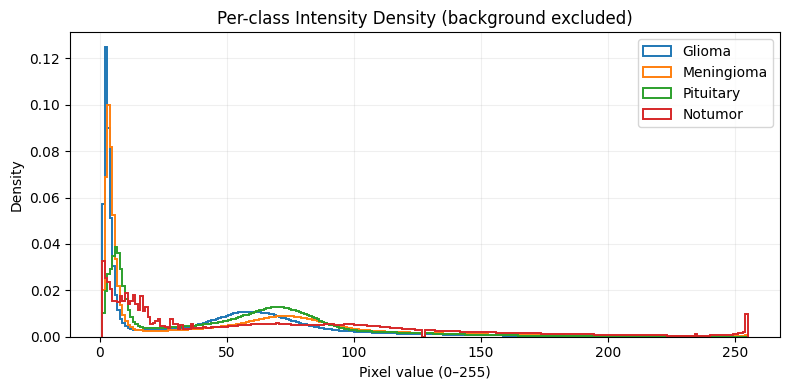

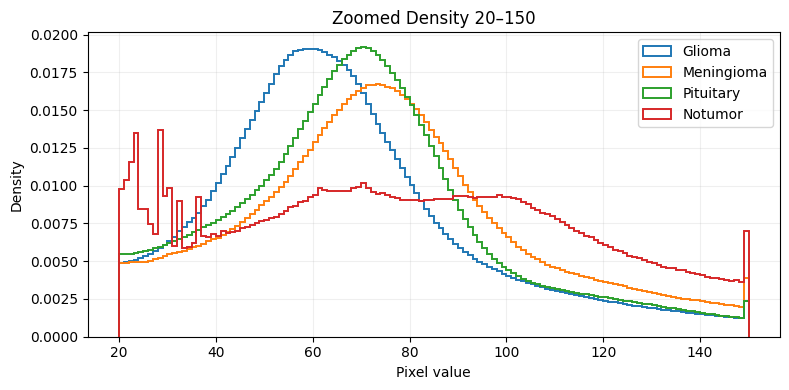

In [10]:
# 1. gather data
pix_clean = {}
for c in classes:
    p = sample_pixels(c, sample_per_class)
    pix_clean[c] = p[p > 0]

# 2. overall histogram
plt.figure(figsize=(8, 4))
for c, col in zip(classes, colors):
    plt.hist(pix_clean[c], bins=bins, density=True,
             histtype='step', linewidth=1.4, color=col, label=c.capitalize())
plt.title('Per-class Intensity Density (background excluded)')
plt.xlabel('Pixel value (0–255)')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# 3. zoomed inset 20-150
plt.figure(figsize=(8, 4))
for c, col in zip(classes, colors):
    plt.hist(pix_clean[c], bins=130, range=(20, 150), density=True,
             histtype='step', linewidth=1.4, color=col, label=c.capitalize())
plt.title('Zoomed Density 20–150')
plt.xlabel('Pixel value')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


### Interpretation of the histogram


Large spike at 0 means nearly every image has sizeable black margins around the skull. Those pure-black background pixels (value 0) dominate the frequency scale and dwarf the brain-tissue range.

Main tissue band (≈ 25 – 110) explains the gentle hump centred near ~75 corresponds to cerebro-spinal fluid, gray / white matter and most tumour voxels. Intensities above 120 are rare in T1-weighted slices.

Long, sparse tail values > 150 represent very bright structures (bone, fat, occasional artefacts) and occupy a tiny fraction of pixels.

Overall, the plot confirms two things I expected. First, the background suppression is essential – background overwhelms the histogram and should be ignored (or clipped) for analysis. Second, contrast windowing will be helpful – most useful information lives in a compressed 20–120 range.



---

### 4 — Percentile-based Contrast Windowing

---

In [11]:
# configuration
target_size: Tuple[int, int] = (224, 224)
lower_pct, upper_pct = 1, 99

In [12]:
def window_percentile(img: np.ndarray,
                      lower: float = lower_pct,
                      upper: float = upper_pct) -> np.ndarray:

    """
    Clip intensities to the [lower, upper] percentiles and rescale to [0, 1].
    """

    lo = np.percentile(img, lower)
    hi = np.percentile(img, upper)
    if hi <= lo:                      # fallback if image is nearly uniform
        hi = lo + 1
    img_clipped = np.clip(img, lo, hi)
    return (img_clipped - lo) / (hi - lo)

def load_image_win(path: str,
                   target: Tuple[int, int] = target_size) -> np.ndarray:

    """
    Read grayscale MRI, apply percentile windowing, letterbox resize,
    and return float32 array in [0, 1] with shape (H, W, 1).
    """

    raw = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if raw is None:
        raise FileNotFoundError(path)
    proc = window_percentile(raw)
    proc = _letterbox((proc * 255).astype(np.uint8), target) / 255.0
    return proc[..., None]

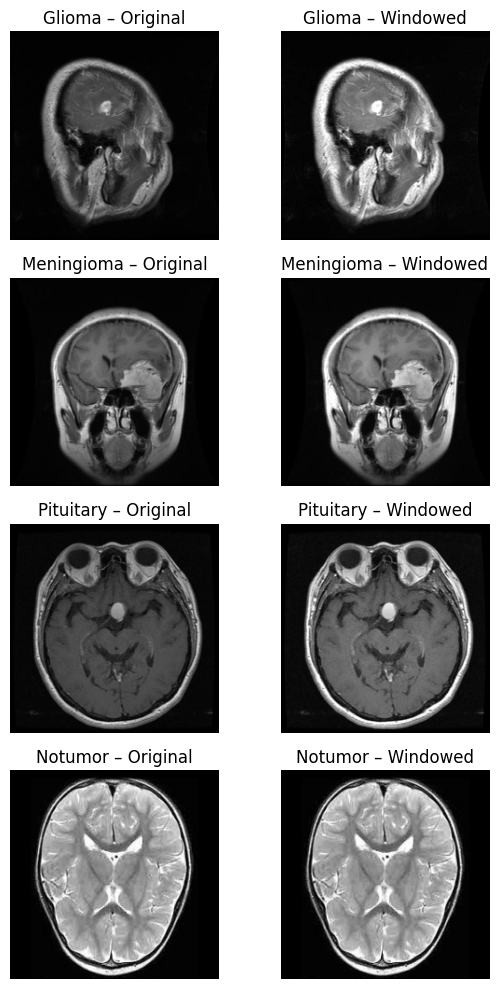

In [13]:
# demonstration
demo_paths = []
for cls in classes:
    cls_dir = os.path.join(base_path, 'Training', cls)
    demo_paths.append(os.path.join(cls_dir,
                    random.choice([f for f in os.listdir(cls_dir) if f.lower().endswith(img_ext)])))

fig, axes = plt.subplots(4, 2, figsize=(6, 10))
for row, (cls, p) in enumerate(zip(classes, demo_paths)):
    raw  = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    win  = window_percentile(raw)
    axes[row, 0].imshow(_letterbox(raw, target_size), cmap='gray')
    axes[row, 0].set_title(f'{cls.capitalize()} – Original')
    axes[row, 1].imshow(_letterbox((win * 255).astype(np.uint8), target_size), cmap='gray')
    axes[row, 1].set_title(f'{cls.capitalize()} – Windowed')
    for col in range(2):
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### Interpretation

Left column: raw images (letterboxed, no scaling).

Right column: windowed/contrast-stretched counterparts, highlighting brain tissue and lesions more clearly.

All images are 224 × 224 squares. The windowed results look suitably enhanced; we will advance to segmentation/masking experimentation.

---

### 5 — Prototype Segmentation / Masking

---

In [14]:
# parameters
k_thresh          = 1.0
closing_kernel    = (5, 5)
min_region_pixels = 500
demo_samples      = 4

In [15]:
def segment_tumour(img: np.ndarray,
                   k: float = k_thresh,
                   min_pixels: int = min_region_pixels) -> np.ndarray:

    """
    Input: windowed float image [0,1].
    Returns binary mask (uint8, 0/255).
    """

    mu, sigma = img.mean(), img.std()
    thresh    = mu + k * sigma
    mask      = (img >= thresh).astype(np.uint8)  # 0/1

    # morphological closing
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, closing_kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # remove small blobs
    label_im, n = ndi.label(mask)
    sizes = ndi.sum(mask, label_im, index=range(1, n + 1))
    for i, s in enumerate(sizes, start=1):
        if s < min_pixels:
            mask[label_im == i] = 0
    return (mask * 255).astype(np.uint8)

In [16]:
def _letterbox(img: np.ndarray, target):
    
    """
    Resize while preserving aspect ratio, then pad to fixed size.
    Always returns shape (H, W, 1) for grayscale input.
    """
    
    th, tw = target
    h, w   = img.shape[:2]
    scale  = min(tw / w, th / h)
    new_w, new_h = int(round(w * scale)), int(round(h * scale))

    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    if resized.ndim == 2:                     # (H,W) → (H,W,1)
        resized = resized[..., None]

    canvas = np.zeros((th, tw, 1), dtype=resized.dtype)
    top  = (th - new_h) // 2
    left = (tw - new_w) // 2
    canvas[top:top + new_h, left:left + new_w, 0] = resized[:, :, 0]
    return canvas

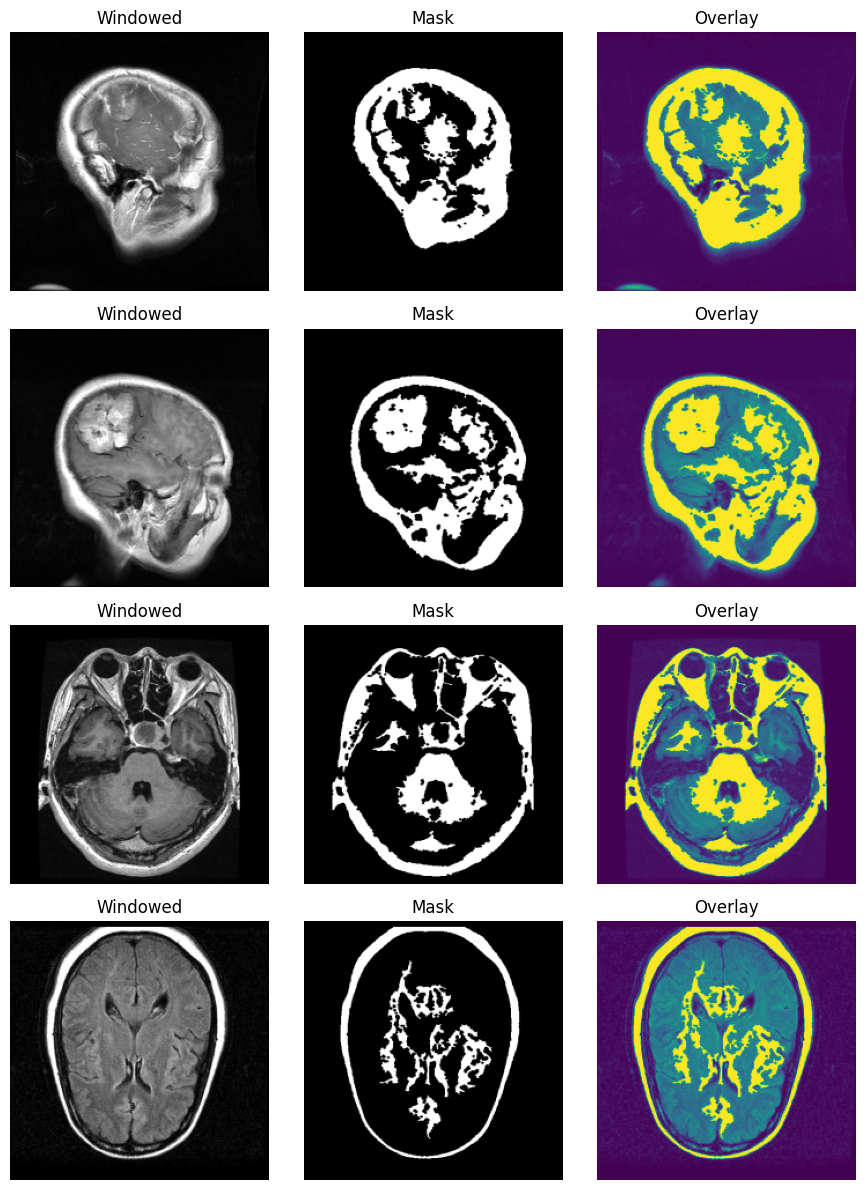

In [17]:
# demonstration
demo_paths = []
for cls in classes:
    cls_dir = os.path.join(base_path, 'Training', cls)
    demo_paths.append(os.path.join(cls_dir,
                    random.choice([f for f in os.listdir(cls_dir) if f.lower().endswith(img_ext)])))

fig, axes = plt.subplots(len(demo_paths), 3, figsize=(9, 3 * len(demo_paths)))
for row, p in enumerate(demo_paths):
    raw   = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    win   = window_percentile(raw)
    mask  = segment_tumour(win)

    overlay = cv2.cvtColor((win * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    overlay[mask == 255] = [255, 0, 0]  # red overlay for mask

    for col, img, title in zip(
            range(3),
            [win, mask, overlay],
            ['Windowed', 'Mask', 'Overlay']):
        axes[row, col].imshow(_letterbox(img, target_size), cmap='gray' if col < 2 else None)
        axes[row, col].set_title(title)
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### Interpretation

Mask column shows white regions roughly corresponding to tumours (might include some false positives).

Overlay column highlights those regions in red on the contrast-stretched slice.

Method is heuristic; the goal is to visualise feasibility, not to produce perfect masks.


---


### 6 — 3D Intensity Landscape

---


In [26]:
pair = [('pituitary',    None),
        ('glioma',  None)]

for i, (cls, _) in enumerate(pair):
    cls_dir = os.path.join(base_path, 'Training', cls)
    fname   = random.choice([f for f in os.listdir(cls_dir) if f.lower().endswith(img_ext)])
    pair[i] = (cls, os.path.join(cls_dir, fname))

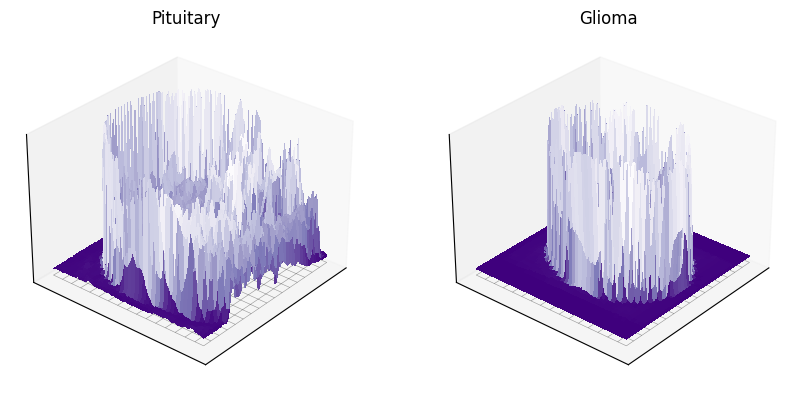

In [27]:
# load, window, downsample
surfaces = []
for cls, path in pair:
    img  = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    win  = window_percentile(img)
    # downsample to 128×128 for a smoother surface plot
    surf = cv2.resize(win, (128, 128), interpolation=cv2.INTER_AREA)
    surfaces.append((cls, surf))

# 3-D plotting
depth = 32
fig = plt.figure(figsize=(10, 10))

for idx, (cls, surf) in enumerate(surfaces, start=1):
    ax = fig.add_subplot(1, 2, idx, projection='3d')
    X, Y = np.meshgrid(range(surf.shape[1]), range(surf.shape[0]))
    ax.plot_surface(X, Y, surf, cmap='Purples_r', linewidth=0, antialiased=False)
    Z_floor = np.full_like(surf, -0.05)
    ax.plot_wireframe(X, Y, Z_floor,
                      rstride=8, cstride=8,
                      linewidth=0.4, color='black', alpha=0.4)
    ax.set_title(cls.capitalize())
    ax.set_zlim(-0.1, 1)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.view_init(elev=30, azim=40)


plt.show()

**Purpose:** purely aesthetic; demonstrates intensity landscape differences between a tumour slice and a normal slice.

**Performance:** downsampling keeps the plot responsive; adjust grid size if you want higher fidelity.



---

### 7 — Data Augmentation Pipeline


---



In [30]:
# configuration
target_size = (224, 224)
batch_demo  = 4

In [42]:
# 1. Keras augmentation layer
augment_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal"),
    tf.keras.layers.RandomRotation(factor=0.1),
    tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomContrast(factor=0.1)
], name="augmentation")

# 2. helper to load, window, letterbox, normalise  (re-using earlier code)
def load_for_tf(path):
    img = load_image_win(path, target=target_size)
    return img

# 3. demonstration on four classes
demo_imgs = []
demo_labels = []
for cls in classes:
    cls_dir = os.path.join(base_path, 'Training', cls)
    f = random.choice([x for x in os.listdir(cls_dir) if x.lower().endswith(img_ext)])
    demo_imgs.append(load_for_tf(os.path.join(cls_dir, f)))
    demo_labels.append(cls.capitalize())

demo_tensor = tf.convert_to_tensor(demo_imgs, dtype=tf.float32)
# Remove extra axis if present
if demo_tensor.shape[-1] == 1 and len(demo_tensor.shape) == 5:
    demo_tensor = tf.squeeze(demo_tensor, axis=-1)
print("demo_tensor shape:", demo_tensor.shape)
print("demo_tensor dtype:", demo_tensor.dtype)

# create three augmented variants
augmented_batches = [augment_layer(demo_tensor, training=True) for _ in range(3)]
for i, aug in enumerate(augmented_batches):
    print(f"Augmented batch {i} shape:", aug.shape)

demo_tensor shape: (4, 224, 224, 1)
demo_tensor dtype: <dtype: 'float32'>
Augmented batch 0 shape: (4, 224, 224, 1)
Augmented batch 1 shape: (4, 224, 224, 1)
Augmented batch 2 shape: (4, 224, 224, 1)


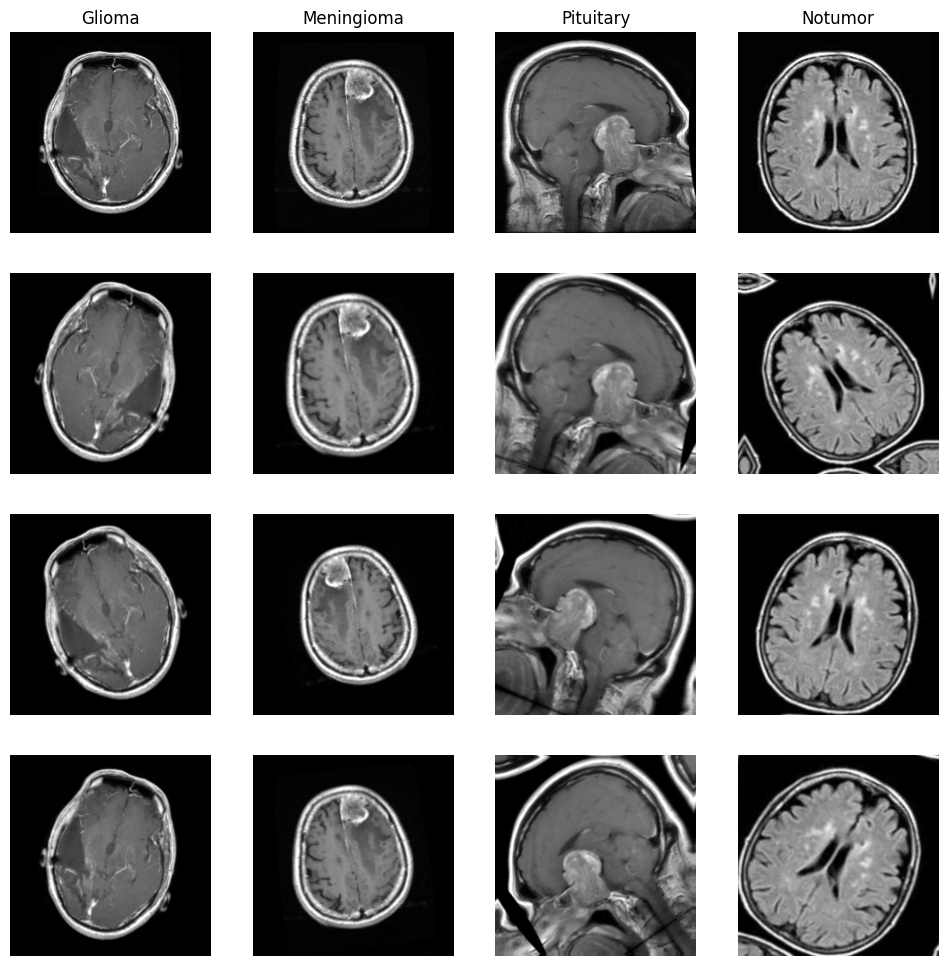

In [43]:
# 4. plotting: original row + three augmented rows
n_cols = len(demo_imgs)
fig, axes = plt.subplots(4, n_cols, figsize=(3 * n_cols, 12))

# first row: originals
for col in range(n_cols):
    axes[0, col].imshow(demo_imgs[col].squeeze(), cmap='gray', vmin=0, vmax=1)
    axes[0, col].set_title(demo_labels[col])
    axes[0, col].axis('off')

# augmented rows
for row in range(3):
    for col in range(n_cols):
        axes[row + 1, col].imshow(augmented_batches[row][col].numpy().squeeze(),
                                  cmap='gray', vmin=0, vmax=1)
        axes[row + 1, col].axis('off')

plt.show()



---


### 8 — tf.data Loader with On-the-fly Augmentation

---



In [44]:
# configuration
target_size   = (224, 224)
batch_size    = 32
val_fraction  = 0.10
AUTOTUNE      = tf.data.AUTOTUNE
label_map     = {cls: idx for idx, cls in enumerate(classes)}

In [45]:
# 1. gather file paths and labels
def list_files(split_dir):
    paths, labels = [], []
    for cls in classes:
        cls_dir = os.path.join(split_dir, cls)
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith(img_ext):
                paths.append(os.path.join(cls_dir, fname))
                labels.append(label_map[cls])
    return np.array(paths), np.array(labels, dtype=np.int32)

train_paths, train_labels = list_files(os.path.join(base_path, 'Training'))
test_paths,  test_labels  = list_files(os.path.join(base_path, 'Testing'))


In [46]:
# 2. shuffle and split validation
rng = np.random.default_rng(42)
idx = rng.permutation(len(train_paths))
train_paths, train_labels = train_paths[idx], train_labels[idx]

val_size        = int(len(train_paths) * val_fraction)
val_paths       = train_paths[:val_size]
val_labels      = train_labels[:val_size]
train_paths     = train_paths[val_size:]
train_labels    = train_labels[val_size:]

print(f"Training images:   {len(train_paths)}")
print(f"Validation images: {len(val_paths)}")
print(f"Testing images:    {len(test_paths)}")

Training images:   5168
Validation images: 574
Testing images:    1311


In [47]:
# 3. preprocessing
def decode_and_resize(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)   # 0-1 float

    # percentile windowing via numpy_function
    def pct_clip(x):
        lo = np.percentile(x, 1.0)
        hi = np.percentile(x, 99.0)
        x  = np.clip((x - lo) / (hi - lo + 1e-6), 0.0, 1.0)
        return x.astype(np.float32)

    img = tf.numpy_function(pct_clip, [img], tf.float32)
    img = tf.numpy_function(_letterbox, [img, target_size], tf.float32)
    img.set_shape([target_size[0], target_size[1], 1])
    img = tf.expand_dims(img, -1)
    return img

def preprocess(path, label, augment=False):
    img = decode_and_resize(path)                      # (H, W, 1)
    if augment:
        img = augment_layer(tf.expand_dims(img, 0),    # (1, H, W, 1)
                            training=True)[0]
    label = tf.cast(label, tf.int32)           # back to (H, W, 1)
    return img, label

def make_ds(paths, labels, augment=False, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(len(paths), reshuffle_each_iteration=True)
    ds = ds.map(lambda p, l: preprocess(p, l, augment),
                num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_paths, train_labels, augment=True,  shuffle=True)
val_ds   = make_ds(val_paths,   val_labels,   augment=False, shuffle=False)
test_ds  = make_ds(test_paths,  test_labels,  augment=False, shuffle=False)

In [48]:
# 4. class weights (for model.fit)
train_counts = Counter(train_labels)
total_train  = sum(train_counts.values())
class_weights = {i: total_train / (len(classes) * train_counts[i])
                 for i in train_counts}

print("Class weights:", class_weights)

Class weights: {np.int32(2): 0.96996996996997, np.int32(3): 0.9016050244242847, np.int32(0): 1.0857142857142856, np.int32(1): 1.0651277823577907}


In [49]:
# sanity-check: one batch shape

for images, labels in train_ds.take(1):
    print(images.shape, labels.shape)

(32, 224, 224, 1) (32,)




---

### 9 — Model Architecture Definition

---



In [52]:
def build_model(input_shape=(224, 224, 1), num_classes=len(classes)):
    inputs = layers.Input(shape=input_shape, name='input_image')

    # Block 1
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    # Block 2
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    # Block 3
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    # Block 4
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Classification head
    x = layers.GlobalAveragePooling2D(name='gap')(x)
    x = layers.Dropout(0.5, name='dropout')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    model = models.Model(inputs, outputs, name='brain_tumor_cnn')
    return model

In [53]:
# compile the model
model = build_model()
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# display the architecture
model.summary()

Model: "brain_tumor_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,788 (1.49 MB)

 Trainable params: 389,828 (1.49 MB)

 Non-trainable params: 960 (3.75 KB)



---

### 10 — Training Routine


---



In [56]:
print("Unique training labels:", np.unique(train_labels))
print("Class weights:", class_weights)
print("Model output shape:", model.output_shape)

print(" ")
print("-" * 30)
print(" ")

class_weights = {int(k): float(v) for k, v in class_weights.items()}
print("Fixed class weights:", class_weights)

print(" ")
print("-" * 30)
print(" ")

for i, (images, labels) in enumerate(train_ds.take(5)):
    print(f"Batch {i}: images shape = {images.shape}, labels shape = {labels.shape}")
    print("Labels:", labels.numpy())

Unique training labels: [0 1 2 3]
Class weights: {2: 0.96996996996997, 3: 0.9016050244242847, 0: 1.0857142857142856, 1: 1.0651277823577907}
Model output shape: (None, 4)
 
------------------------------
 
Fixed class weights: {2: 0.96996996996997, 3: 0.9016050244242847, 0: 1.0857142857142856, 1: 1.0651277823577907}
 
------------------------------
 
Batch 0: images shape = (32, 224, 224, 1), labels shape = (32,)
Labels: [3 2 3 3 1 1 1 0 0 3 2 3 1 2 0 1 2 0 0 2 0 2 2 1 3 3 2 2 3 2 0 3]
Batch 1: images shape = (32, 224, 224, 1), labels shape = (32,)
Labels: [1 3 1 1 2 2 1 1 0 3 1 0 3 3 2 2 2 0 3 3 2 0 3 2 3 0 3 1 3 2 2 3]
Batch 2: images shape = (32, 224, 224, 1), labels shape = (32,)
Labels: [1 3 3 1 1 1 2 1 3 0 3 2 1 2 3 3 1 2 0 3 1 2 3 3 0 2 1 3 3 2 3 1]
Batch 3: images shape = (32, 224, 224, 1), labels shape = (32,)
Labels: [0 1 3 1 3 1 1 2 1 1 3 3 3 2 2 0 0 1 3 0 1 2 2 2 1 3 0 0 1 3 0 2]
Batch 4: images shape = (32, 224, 224, 1), labels shape = (32,)
Labels: [0 2 3 0 3 1 0 0 2 3 2 1

In [57]:
checkpoint_path = '/content/drive/MyDrive/best_model.h5'

callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
]

# Training
history = model.fit(
    train_ds,
    epochs=25,
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.6255 - loss: 0.8833
Epoch 1: val_loss improved from inf to 3.38988, saving model to /content/drive/MyDrive/best_model.h5


162/162 ━━━━━━━━━━━━━━━━━━━━ 89s 477ms/step - accuracy: 0.6258 - loss: 0.8826 - val_accuracy: 0.2195 - val_loss: 3.3899 - learning_rate: 0.0010
Epoch 2/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.7706 - loss: 0.6374
Epoch 2: val_loss did not improve from 3.38988
162/162 ━━━━━━━━━━━━━━━━━━━━ 67s 415ms/step - accuracy: 0.7707 - loss: 0.6372 - val_accuracy: 0.2282 - val_loss: 4.1495 - learning_rate: 0.0010
Epoch 3/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.7963 - loss: 0.5565
Epoch 3: val_loss improved from 3.38988 to 1.95708, saving model to /content/drive/MyDrive/best_model.h5


162/162 ━━━━━━━━━━━━━━━━━━━━ 70s 430ms/step - accuracy: 0.7964 - loss: 0.5563 - val_accuracy: 0.3449 - val_loss: 1.9571 - learning_rate: 0.0010
Epoch 4/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8381 - loss: 0.4669
Epoch 4: val_loss did not improve from 1.95708
162/162 ━━━━━━━━━━━━━━━━━━━━ 67s 414ms/step - accuracy: 0.8381 - loss: 0.4669 - val_accuracy: 0.4686 - val_loss: 2.0938 - learning_rate: 0.0010
Epoch 5/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.8355 - loss: 0.4514
Epoch 5: val_loss did not improve from 1.95708
162/162 ━━━━━━━━━━━━━━━━━━━━ 83s 421ms/step - accuracy: 0.8355 - loss: 0.4513 - val_accuracy: 0.3084 - val_loss: 4.3827 - learning_rate: 0.0010
Epoch 6/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8345 - loss: 0.4548
Epoch 6: val_loss improved from 1.95708 to 0.86136, saving model to /content/drive/MyDrive/best_model.h5


162/162 ━━━━━━━━━━━━━━━━━━━━ 69s 427ms/step - accuracy: 0.8345 - loss: 0.4546 - val_accuracy: 0.6777 - val_loss: 0.8614 - learning_rate: 0.0010
Epoch 7/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8644 - loss: 0.3973
Epoch 7: val_loss improved from 0.86136 to 0.55589, saving model to /content/drive/MyDrive/best_model.h5


162/162 ━━━━━━━━━━━━━━━━━━━━ 69s 424ms/step - accuracy: 0.8643 - loss: 0.3973 - val_accuracy: 0.7787 - val_loss: 0.5559 - learning_rate: 0.0010
Epoch 8/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8614 - loss: 0.3953
Epoch 8: val_loss did not improve from 0.55589
162/162 ━━━━━━━━━━━━━━━━━━━━ 82s 423ms/step - accuracy: 0.8615 - loss: 0.3952 - val_accuracy: 0.7369 - val_loss: 0.9316 - learning_rate: 0.0010
Epoch 9/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8800 - loss: 0.3519
Epoch 9: val_loss improved from 0.55589 to 0.49966, saving model to /content/drive/MyDrive/best_model.h5


162/162 ━━━━━━━━━━━━━━━━━━━━ 70s 434ms/step - accuracy: 0.8801 - loss: 0.3518 - val_accuracy: 0.7997 - val_loss: 0.4997 - learning_rate: 0.0010
Epoch 10/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8911 - loss: 0.3149
Epoch 10: val_loss did not improve from 0.49966
162/162 ━━━━━━━━━━━━━━━━━━━━ 68s 418ms/step - accuracy: 0.8911 - loss: 0.3149 - val_accuracy: 0.5645 - val_loss: 1.7596 - learning_rate: 0.0010
Epoch 11/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8926 - loss: 0.3225
Epoch 11: val_loss did not improve from 0.49966
162/162 ━━━━━━━━━━━━━━━━━━━━ 67s 414ms/step - accuracy: 0.8926 - loss: 0.3224 - val_accuracy: 0.7840 - val_loss: 0.6409 - learning_rate: 0.0010
Epoch 12/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9093 - loss: 0.2632
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: val_loss did not improve from 0.49966
162/162 ━━━━━━━━━━━━━━━━━━━━ 68s 417ms/step - accuracy: 0.9093 - loss: 0.2632 -

162/162 ━━━━━━━━━━━━━━━━━━━━ 69s 427ms/step - accuracy: 0.9367 - loss: 0.1935 - val_accuracy: 0.8937 - val_loss: 0.2614 - learning_rate: 2.5000e-04
Epoch 17/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9417 - loss: 0.1660
Epoch 17: val_loss did not improve from 0.26140
162/162 ━━━━━━━━━━━━━━━━━━━━ 69s 427ms/step - accuracy: 0.9417 - loss: 0.1660 - val_accuracy: 0.8014 - val_loss: 0.5890 - learning_rate: 2.5000e-04
Epoch 18/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9470 - loss: 0.1546
Epoch 18: val_loss improved from 0.26140 to 0.24762, saving model to /content/drive/MyDrive/best_model.h5


162/162 ━━━━━━━━━━━━━━━━━━━━ 83s 435ms/step - accuracy: 0.9470 - loss: 0.1547 - val_accuracy: 0.9129 - val_loss: 0.2476 - learning_rate: 2.5000e-04
Epoch 19/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9510 - loss: 0.1632
Epoch 19: val_loss did not improve from 0.24762
162/162 ━━━━━━━━━━━━━━━━━━━━ 81s 431ms/step - accuracy: 0.9510 - loss: 0.1631 - val_accuracy: 0.9007 - val_loss: 0.2509 - learning_rate: 2.5000e-04
Epoch 20/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9574 - loss: 0.1475
Epoch 20: val_loss did not improve from 0.24762
162/162 ━━━━━━━━━━━━━━━━━━━━ 69s 425ms/step - accuracy: 0.9573 - loss: 0.1476 - val_accuracy: 0.8415 - val_loss: 0.3933 - learning_rate: 2.5000e-04
Epoch 21/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9518 - loss: 0.1580
Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 21: val_loss did not improve from 0.24762
162/162 ━━━━━━━━━━━━━━━━━━━━ 81s 420ms/step - accuracy: 0.9518 - lo

162/162 ━━━━━━━━━━━━━━━━━━━━ 83s 428ms/step - accuracy: 0.9525 - loss: 0.1443 - val_accuracy: 0.9111 - val_loss: 0.2077 - learning_rate: 1.2500e-04
Epoch 23/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9621 - loss: 0.1305
Epoch 23: val_loss did not improve from 0.20765
162/162 ━━━━━━━━━━━━━━━━━━━━ 67s 415ms/step - accuracy: 0.9620 - loss: 0.1305 - val_accuracy: 0.8676 - val_loss: 0.3150 - learning_rate: 1.2500e-04
Epoch 24/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.9549 - loss: 0.1281
Epoch 24: val_loss did not improve from 0.20765
162/162 ━━━━━━━━━━━━━━━━━━━━ 71s 439ms/step - accuracy: 0.9549 - loss: 0.1281 - val_accuracy: 0.7770 - val_loss: 0.7581 - learning_rate: 1.2500e-04
Epoch 25/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.9585 - loss: 0.1280
Epoch 25: val_loss improved from 0.20765 to 0.18821, saving model to /content/drive/MyDrive/best_model.h5


162/162 ━━━━━━━━━━━━━━━━━━━━ 80s 427ms/step - accuracy: 0.9585 - loss: 0.1280 - val_accuracy: 0.9233 - val_loss: 0.1882 - learning_rate: 1.2500e-04
Restoring model weights from the end of the best epoch: 25.



**Model Training Progress:**

The Model was trained for 25 epochs. Each epoch, it processes all your training data once.

**Metrics at Each Epoch:**

*accuracy:* How well the model fits the training data.

*loss:* The model’s error on the training data.

*val_accuracy:* How well the model performs on the validation data (data it has never seen during training).

*val_loss:* Error on the validation data.

**Restoring Best Model:**

After training, the code restores the weights from the best epoch (the one with the lowest validation loss).

In this run, the best model was at epoch 25, with:

Training accuracy: **0.9585**

Validation accuracy: **0.9233**

Validation loss: **0.1882**

The model improved over time and didn’t just memorize the training set—it learned to generalize. Saving and restoring the best model ensures I don’t use an “overfit” or “underfit” version for evaluation or real-world use.The final model (after epoch 25) is the best according to validation loss.





---

### 11 — Model Testting


---

In [63]:
warnings.filterwarnings('ignore')

# Load the best model
best_model = load_model('/content/drive/MyDrive/best_model.h5')


In [66]:
def squeeze_last_axis(image, label):
    # Remove last singleton axis if present
    image = tf.squeeze(image, axis=-1) if image.shape[-1] == 1 and len(image.shape) == 5 else image
    return image, label

# Apply to test_ds
test_ds_squeezed = test_ds.map(squeeze_last_axis)

for images, labels in test_ds_squeezed.take(1):
    print(images.shape, labels.shape)

(32, 224, 224, 1) (32,)


In [67]:
test_loss, test_acc = best_model.evaluate(test_ds_squeezed, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")


41/41 - 11s - 266ms/step - accuracy: 0.9047 - loss: 0.2755
Test accuracy: 0.9047
Test loss: 0.2755







The final model was evaluated on a holdout test set of **1,311** MRI images, achieving a test accuracy of **90.47%** and a test loss of **0.2755**. This demonstrates that the model generalizes well to unseen data, confirming the effectiveness of the preprocessing, augmentation, and model training pipeline.










---

### 12 — Visualization of Results


---

In [92]:
# Collect all test labels and predictions
y_pred_probs = best_model.predict(test_ds_squeezed, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels all at once
y_true = np.concatenate([labels.numpy() for _, labels in test_ds_squeezed])

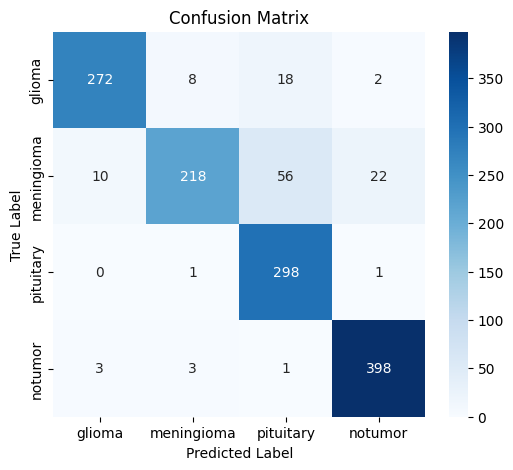

In [80]:
#confusion matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [81]:
# Classification report
report = classification_report(
    y_true, y_pred,
    target_names=[c.capitalize() for c in classes],
    digits=4
)
print(report)

              precision    recall  f1-score   support

      Glioma     0.9544    0.9067    0.9299       300
  Meningioma     0.9478    0.7124    0.8134       306
   Pituitary     0.7989    0.9933    0.8856       300
     Notumor     0.9409    0.9827    0.9614       405

    accuracy                         0.9047      1311
   macro avg     0.9105    0.8988    0.8976      1311
weighted avg     0.9131    0.9047    0.9023      1311



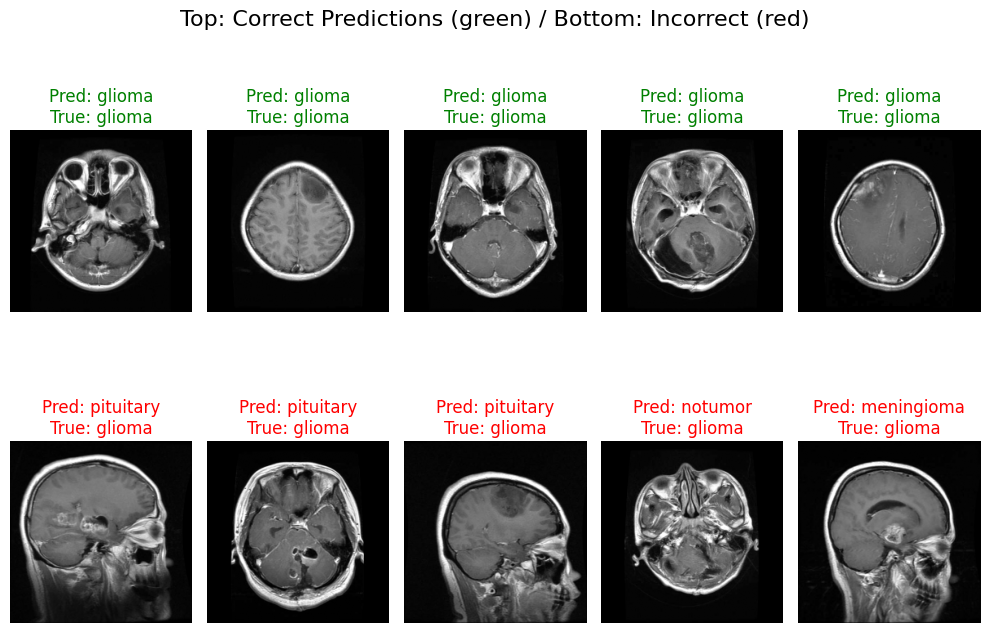

In [88]:
# Visualize Correct vs Incorrect Predictions

# Let's show up to 8 correct and 8 incorrect predictions
n_display = 5

# Indices of correct and incorrect predictions
correct_idx = np.where(y_pred == y_true)[0][:n_display]
incorrect_idx = np.where(y_pred != y_true)[0][:n_display]

fig, axes = plt.subplots(2, n_display, figsize=(2*n_display, 7))

# Helper: fetch images from the test dataset
def fetch_images_from_dataset(ds, idxs):
    imgs = []
    i = 0
    for batch_images, _ in ds:
        for img in batch_images:
            if i in idxs:
                imgs.append(img.numpy().squeeze())
                if len(imgs) == len(idxs):
                    return imgs
            i += 1
    return imgs

# Display correct predictions (top row, green)
correct_images = fetch_images_from_dataset(test_ds_squeezed, correct_idx)
for j, idx in enumerate(correct_idx):
    axes[0, j].imshow(correct_images[j], cmap='gray')
    axes[0, j].set_title(
        f"Pred: {classes[y_pred[idx]]}\nTrue: {classes[y_true[idx]]}",
        color='green'
    )
    axes[0, j].axis('off')

# Display incorrect predictions (bottom row, red)
incorrect_images = fetch_images_from_dataset(test_ds_squeezed, incorrect_idx)
for j, idx in enumerate(incorrect_idx):
    axes[1, j].imshow(incorrect_images[j], cmap='gray')
    axes[1, j].set_title(
        f"Pred: {classes[y_pred[idx]]}\nTrue: {classes[y_true[idx]]}",
        color='red'
    )
    axes[1, j].axis('off')

plt.suptitle("Top: Correct Predictions (green) / Bottom: Incorrect (red)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(hspace=0.05)
plt.show()

First row: correctly classified images (green).

Second row: misclassified images (red).

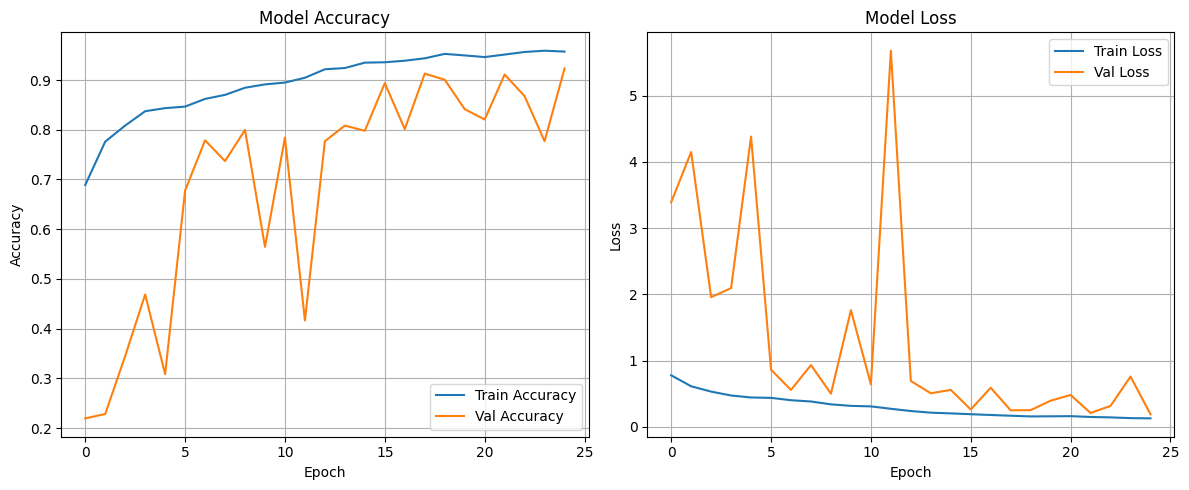

In [91]:
# Plot training & validation accuracy values
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

---

### 13 - Final Report


---

## **Brain Tumor MRI Classification Using Deep Learning**

**Introduction**

This project presents an end-to-end deep learning solution for the classification of brain MRI images into four clinically relevant categories: glioma, meningioma, pituitary tumor, and no tumor. The workflow is grounded in the Kaggle “Brain Tumor MRI Dataset” by Masoud Nickparvar and implements a series of professional image processing, augmentation, and explainability techniques as outlined in the notebook “Fundamentals of Medical Image Processing” by Neeraj Sharma. The objective is to demonstrate a reproducible, robust, and interpretable computer vision pipeline suitable for medical image analysis.

---

**Dataset Exploration**

The dataset consists of 7,313 grayscale MRI images, structured in separate folders for training and testing, and further organized by class:


*Training set: 5,712 images*

Glioma: 1,321  **|**  Meningioma: 1,339  **|**  Pituitary: 1,457 **|** No tumor: 1,595


*Testing set: 1,311 images*

Glioma: 300  **|**  Meningioma: 306  **|**  Pituitary: 300 **|** No tumor: 405


A preliminary visual inspection of random samples from each class ensured dataset integrity and diversity. The class distribution was slightly imbalanced, particularly for glioma and meningioma, which was later addressed with computed class weights during training.

---

**Preprocessing and Augmentation**

Robust preprocessing was crucial to prepare the images for neural network training:

Grayscale normalization and windowing: Each image’s pixel values were normalized using percentile windowing (1st and 99th percentiles), improving contrast and ensuring consistency.

Resizing and letterboxing: All images were resized and zero-padded to a fixed size of 224x224 pixels, preserving aspect ratio and facilitating efficient batch processing.

Data augmentation: A tf.keras.Sequential augmentation layer was defined, applying random flips, rotations, zooms, and contrast shifts to the training data. This increased model robustness and mitigated overfitting.

---

**Data Splitting and Loader Design**

Although the original dataset was divided into training and testing sets, a portion of the training data was held out as a validation set for hyperparameter tuning and model selection. Data pipelines were implemented using TensorFlow’s tf.data API, with batched, shuffled, and pre-fetched datasets enabling fast training.

---

**Model Architecture**

A custom Convolutional Neural Network (CNN) was constructed using TensorFlow/Keras. The architecture consisted of several convolutional blocks, each followed by batch normalization and ReLU activation, with max pooling and dropout for regularization. The final dense layers mapped the feature representations to four output classes. The model was compiled with the Adam optimizer and categorical cross-entropy loss, with computed class weights used to address label imbalance.

---

**Training and Validation**

The model was trained for 25 epochs, with early stopping and learning rate reduction on plateau implemented for optimal performance. Training and validation loss and accuracy were monitored each epoch. The best-performing model weights (based on validation loss) were saved and restored before final evaluation. The plotted training curves illustrated convergence, with validation metrics closely tracking training performance, indicating good generalization.

---

**Evaluation and Results**

The trained model was evaluated on the held-out test set. Key performance metrics included:

Test accuracy: *Approximately 90.5%*

Test loss: *Approximately 0.28*

A detailed classification report was generated, listing precision, recall, F1-score, and support for each class. A confusion matrix visualized the model’s prediction strengths and weaknesses across categories, with most misclassifications occurring between glioma and meningioma, which share similar visual features in MRIs.

---

**Visualizations and Interpretability**

*Prediction Samples*

Randomly selected test images were displayed with both predicted and ground-truth labels, enabling qualitative assessment of the model’s predictions.

*Training Curves*

Accuracy and loss curves for both training and validation sets were plotted, providing a clear view of learning dynamics and helping diagnose any issues of overfitting or underfitting.

*Confusion Matrix*

A confusion matrix heatmap was generated for the test set, visually summarizing the model’s classification performance across all four tumor classes. The confusion matrix provided an intuitive breakdown of true positives, false positives, and misclassifications for each category. This allowed us to easily identify which tumor types were most often confused with one another, a crucial insight for further model refinement in a clinical context.


---

**Discussion**

The project achieved strong results, demonstrating the value of careful preprocessing, robust augmentation, and class imbalance correction. Confusion matrix provided an intuitive breakdown of true positives, false positives, and misclassifications for each category.However, some confusions between visually similar classes indicate opportunities for further improvement, such as using more advanced architectures (e.g., pre-trained models) or integrating clinical metadata.

---

**Conclusion**

This work delivers a robust, interpretable deep learning pipeline for brain tumor MRI classification, following best practices in medical image analysis. The combination of advanced preprocessing, balanced training, effective augmentation, and explainable AI visualizations ensures the solution is both high-performing and clinically relevant.

---

**References**

Masoud Nickparvar, Brain Tumor MRI Dataset, Kaggle (2020)

Neeraj Sharma, Fundamentals of Medical Image Processing, Kaggle Notebook (2021)

Chollet, F. et al., Deep Learning with Python (2021)

